$$ ITI \space AI-Pro: \space Intake \space 45 $$
$$ Deep \space Learning $$
$$ Lab \space no. \space 4 $$

# `01` Assignment 01
- Design your own U-Net to segment the lung fields from chest computed tomography CT images (download from [here](https://drive.google.com/file/d/1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9/view?usp=sharing)) into one of the 2 classes lung or chest (background)
- Image Size: $512\times512\times1$
- Use a generator to load the images
(**Hint:** You can use `tensorflow.keras.utils.image_dataset_from_directory`)
- Use 85% of the provided data for training and 15% for validation.
- Use $32 → 64 → 128 → 256 → 512 → 256 → 128 → 64 → 32$ architecture.
- Use $3\times3$ **Convolution**, $2\times2$ **MaxPooling**
- Use `binary_crossentropy` for the loss calculation, `Adam` for optimization and `accuracy` for metrics.

## `+` Import Libraries

In [10]:
import gdown
from glob import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [11]:
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras import layers, models

In [12]:
from layers import Input, Dense, Activation, Conv2D, MaxPool2D, Flatten, Dropout, Conv2DTranspose, Concatenate, Lambda, Cropping2D, BatchNormalization
from layers import  RandomTranslation, RandomContrast,Rescaling, RandomFlip, RandomRotation, RandomZoom
from models import Sequential, Model
from keras.preprocessing import image_dataset_from_directory
from keras.callbacks import EarlyStopping

from keras.applications import MobileNetV2


In [ ]:
import requests
from io import BytesIO
from PIL import Image

# `+` Set Global Parameters

In [61]:
# Seed
SEED = 934
# Hyperparameters
BATCH_SIZE = 8
EPOCHS = 30

## `+` Downlaod, Load Chest CT Data

### Download & Extract the Dataset

In [60]:
gdown.download(id='1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9')

Downloading...
From (original): https://drive.google.com/uc?id=1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9
From (redirected): https://drive.google.com/uc?id=1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9&confirm=t&uuid=a8cfebdb-46db-40ef-9582-7943ff2653ce
To: /content/Lung_Data.zip
100%|██████████| 41.1M/41.1M [00:00<00:00, 276MB/s]


'Lung_Data.zip'

In [62]:
%%capture
!unzip Lung_Data.zip

### Load & Preprocess the Dataset

**Reminder:** You might need rescaling, data augmentation, and/or other preprocessing methods.

In [63]:
folders = ['grey', 'mask']
for folder in folders:
    out_dir = f'Lung_Data_PNG/{folder}'
    os.makedirs(out_dir, exist_ok=True)
    for img in glob(f'Lung_Data/{folder}/*.bmp'):
        Image.open(img).save(os.path.join(out_dir, img.split('/')[-1].rsplit('.', maxsplit=1)[0] + '.png'), 'PNG')

In [64]:
# Grey Dataset
grey_train_ds, grey_val_ds = image_dataset_from_directory('Lung_Data_PNG/grey',
                                                batch_size=BATCH_SIZE,
                                                seed=SEED,
                                                image_size=(512, 512),
                                                color_mode="grayscale",
                                                labels=None,
                                                validation_split=0.15,
                                                subset="both")


Found 216 files.
Using 184 files for training.
Using 32 files for validation.


In [65]:
# Mask Dataset
mask_train_ds, mask_val_ds = image_dataset_from_directory('Lung_Data_PNG/mask',
                                                batch_size=BATCH_SIZE,
                                                seed=SEED,
                                                image_size=(512, 512),
                                                color_mode="grayscale",
                                                labels=None,
                                                validation_split=0.15,
                                                subset="both")

Found 216 files.
Using 184 files for training.
Using 32 files for validation.


### Preview the Images

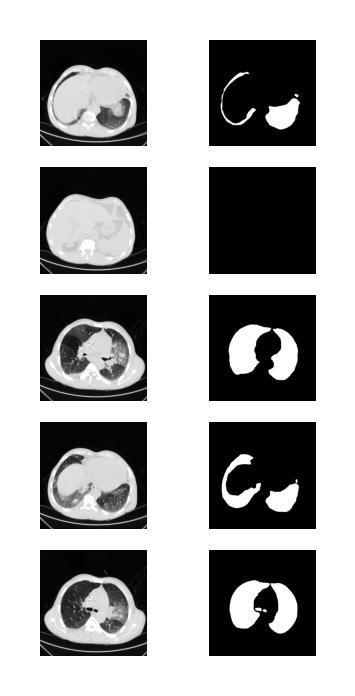

In [ ]:
# Preview Images
plt.figure(figsize=(1, 2), dpi=400)
for images, masks in zip(grey_train_ds.take(4), mask_train_ds.take(4)):
    for i in range(5):
        plt.subplot(5, 2, i*2+1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
        plt.subplot(5, 2, i*2+2)
        plt.imshow(masks[i], cmap='gray')
        plt.axis('off')

## `+` Preprocessing & Augmentation

In [66]:
def augment_data(image, mask, layers):
    for layer in layers:
        image = layer(image, training=True)
        mask = layer(mask, training=True)
    return image, mask

In [67]:
train_ds = tf.data.Dataset.zip((grey_train_ds, mask_train_ds))

In [68]:
# Augmentation Layers
layers = [
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomTranslation(0.1, 0.1)
]

# Augment data
augmented_train_ds =train_ds.map(lambda img, mask: augment_data(img, mask, layers))

# Normalize masks manually (Rescaling 1./255)
augmented_train_ds = augmented_train_ds.map(lambda img, mask: (img, tf.cast(mask, tf.float32) / 255.0))
segment_val = tf.data.Dataset.zip((grey_val_ds, mask_val_ds.map(lambda x: tf.cast(x, tf.float32) / 255.0)))


In [69]:
AUTOTUNE = tf.data.AUTOTUNE
augmented_train_ds = augmented_train_ds.cache().shuffle(100).prefetch(buffer_size=AUTOTUNE)
segment_val = segment_val.cache().prefetch(buffer_size=AUTOTUNE)

## `i` Model Design

## `#` First trail

### `01` Define Building Blocks

In [11]:
def conv(x, n_filters):
    x = Conv2D(n_filters, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Conv2D(n_filters, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    return x

In [12]:
def downsample_block(x, n_filters):
    f = conv(x, n_filters)
    p = MaxPool2D(2,2)(f)
    return f, p

In [13]:
def upsample_block(x, n_filters, skip_features):
    x = Conv2DTranspose(n_filters, (2, 2), 2, padding='same')(x)
    x = Concatenate()([x, skip_features])
    x = conv(x, n_filters)
    return x

### `02` Build Model Structure

In [ ]:
inputs = Input((512, 512, 1))

# Rescaling
scaled_inputs = Rescaling(1.0/255.0)(inputs)

# Encoder
f1, p1 = downsample_block(scaled_inputs, 32)
f2, p2 = downsample_block(p1, 64)
f3, p3 = downsample_block(p2, 128)
f4, p4 = downsample_block(p3, 256)

# Bottleneck
bottleneck = conv(p4, 512)
bottleneck = Dropout(0.5)(bottleneck)


# Decoder
u4 = upsample_block(bottleneck, 256, f4)
u3 = upsample_block(u4, 128, f3)
u2 = upsample_block(u3, 64, f2)
u1 = upsample_block(u2, 32, f1)

# Output (Mask)
outputs = Conv2D(1, (1,1), activation='sigmoid', padding='same')(u1)

model = Model(inputs, outputs, name='CIT_UNet')

model.summary()


Model: "CIT_UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 512, 512,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        320 │ rescaling[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512, 512,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ batch_normalizat

 Total params: 7,771,297 (29.65 MB)

 Trainable params: 7,765,409 (29.62 MB)

 Non-trainable params: 5,888 (23.00 KB)

## `ii` Model Compilation & Training

In [14]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


In [15]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [ ]:
model.compile(optimizer='adam',
              loss=dice_loss,
              metrics=[dice_coef])

In [ ]:
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(
    x=augmented_train_ds,
    epochs=EPOCHS,
    validation_data=segment_val,
    steps_per_epoch=grey_train_ds.cardinality().numpy(),
    validation_steps=grey_val_ds.cardinality().numpy(),
    callbacks=[early_stop]
)


Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - dice_coef: 0.3006 - loss: 0.6994 - val_dice_coef: 4.5736e-12 - val_loss: 1.0000
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 620ms/step - dice_coef: 0.4117 - loss: 0.5883 - val_dice_coef: 0.0463 - val_loss: 0.9537
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 611ms/step - dice_coef: 0.4335 - loss: 0.5665 - val_dice_coef: 0.1942 - val_loss: 0.8058
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 601ms/step - dice_coef: 0.4424 - loss: 0.5576 - val_dice_coef: 0.1942 - val_loss: 0.8058
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 614ms/step - dice_coef: 0.4656 - loss: 0.5344 - val_dice_coef: 0.2108 - val_loss: 0.7892
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 621ms/step - dice_coef: 0.4661 - loss: 0.5339 - val_dice_coef: 0.2143 - val_loss: 0.7857
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 614ms/step - dice_coef: 0.4691 - loss: 0.5309 - val_dice_coef: 0.2023 - val_loss: 0.7977
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 618ms/step - dice_coef: 0.4676 - loss: 

## `iii` Model Evaluation

In [ ]:
# Evaluate on training data
loss_train, accuracy_train = model.evaluate(augmented_train_ds)
print(f"Accuracy for training: {accuracy_train:.4%}")

# Evaluate on validation data
loss_test, accuracy_test = model.evaluate(segment_val)
print(f"Accuracy for testing: {accuracy_test:.4%}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - dice_coef: 0.4775 - loss: 0.5225
Accuracy for training: 47.6684%
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - dice_coef: 0.6815 - loss: 0.3185
Accuracy for testing: 67.0164%


## `iv` Result Visualization

In [ ]:
print(history.history.keys())

dict_keys(['dice_coef', 'loss', 'val_dice_coef', 'val_loss'])


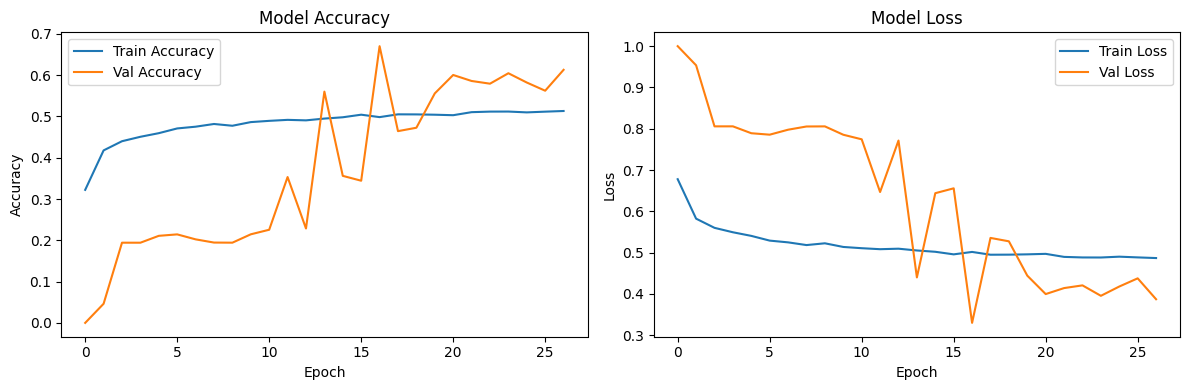

In [ ]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['dice_coef'], label='Train Accuracy')
plt.plot(history.history['val_dice_coef'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## `#` Second trail

### `i` Build Model Structure

In [50]:

def conv_block(x, filters):
    x = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def encoder_block(x, filters):
    f = conv_block(x, filters)
    p = MaxPooling2D((2, 2))(f)
    return f, p

def decoder_block(x, skip_features, filters):
    x = Conv2DTranspose(filters, (2, 2), strides=2, padding='same')(x)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, filters)
    return x

def build_unet(input_shape=(512, 512, 1)):
    inputs = Input(input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bottleneck
    b = conv_block(p4, 1024)
    b = Dropout(0.5)(b)

    # Decoder
    d4 = decoder_block(b, s4, 512)
    d3 = decoder_block(d4, s3, 256)
    d2 = decoder_block(d3, s2, 128)
    d1 = decoder_block(d2, s1, 64)

    # Output
    outputs = Conv2D(1, (1, 1), padding='same', activation='sigmoid')(d1)

    model = Model(inputs, outputs, name="Improved_UNet")
    return model


## `ii` Model Compilation & Training

In [51]:
model = build_unet(input_shape=(512, 512, 1))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "Improved_UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        640 │ input_layer_8[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512, 512,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │      1,024 │ conv2d_4[0][0]  

 Total params: 31,054,145 (118.46 MB)

 Trainable params: 31,042,369 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [ ]:
history = model.fit(
    x=augmented_train_ds,
    epochs=10,
    validation_data=segment_val,
    steps_per_epoch=grey_train_ds.cardinality().numpy(),
    validation_steps=grey_val_ds.cardinality().numpy()
)

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8862 - loss: 0.2605 - val_accuracy: 0.9206 - val_loss: 1.6139
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8859 - loss: 0.2599 - val_accuracy: 0.9240 - val_loss: 0.1946
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8915 - loss: 0.2492 - val_accuracy: 0.7312 - val_loss: 0.5578
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8855 - loss: 0.2433 - val_accuracy: 0.8455 - val_loss: 0.2602
Epoch 5/10


## `iii` Model Evaluation

In [ ]:
# Evaluate on training data
loss_train, accuracy_train = model.evaluate(augmented_train_ds)
print(f"Accuracy for training: {accuracy_train:.4%}")

# Evaluate on validation data
loss_test, accuracy_test = model.evaluate(segment_val)
print(f"Accuracy for testing: {accuracy_test:.4%}")

## `iv` Result Visualization

In [ ]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## `v` It's Time for Segmentation!!

Let's try to predict the mask of some validation samples and plot the results.

In [ ]:
def visualize_with_multiple_thresholds(model, val_ds, num_samples=3):
    thresholds = [0.3, 0.4, 0.5]

    for images, masks in val_ds.take(1):
        preds = model.predict(images)

        for i in range(min(num_samples, len(images))):
            plt.figure(figsize=(20, 5))

            # Original CT Image
            plt.subplot(1, 5, 1)
            plt.imshow(images[i].numpy().squeeze(), cmap='gray')
            plt.title("CT Image")
            plt.axis('off')

            # True Mask
            plt.subplot(1, 5, 2)
            plt.imshow(masks[i].numpy().squeeze(), cmap='gray')
            plt.title("True Mask")
            plt.axis('off')

            # Predicted Masks with different thresholds
            for j, t in enumerate(thresholds):
                plt.subplot(1, 5, 3 + j)
                plt.imshow(preds[i].squeeze() > t, cmap='gray')
                plt.title(f"Predicted Mask\nThreshold = {t}")
                plt.axis('off')

            plt.tight_layout()
            plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


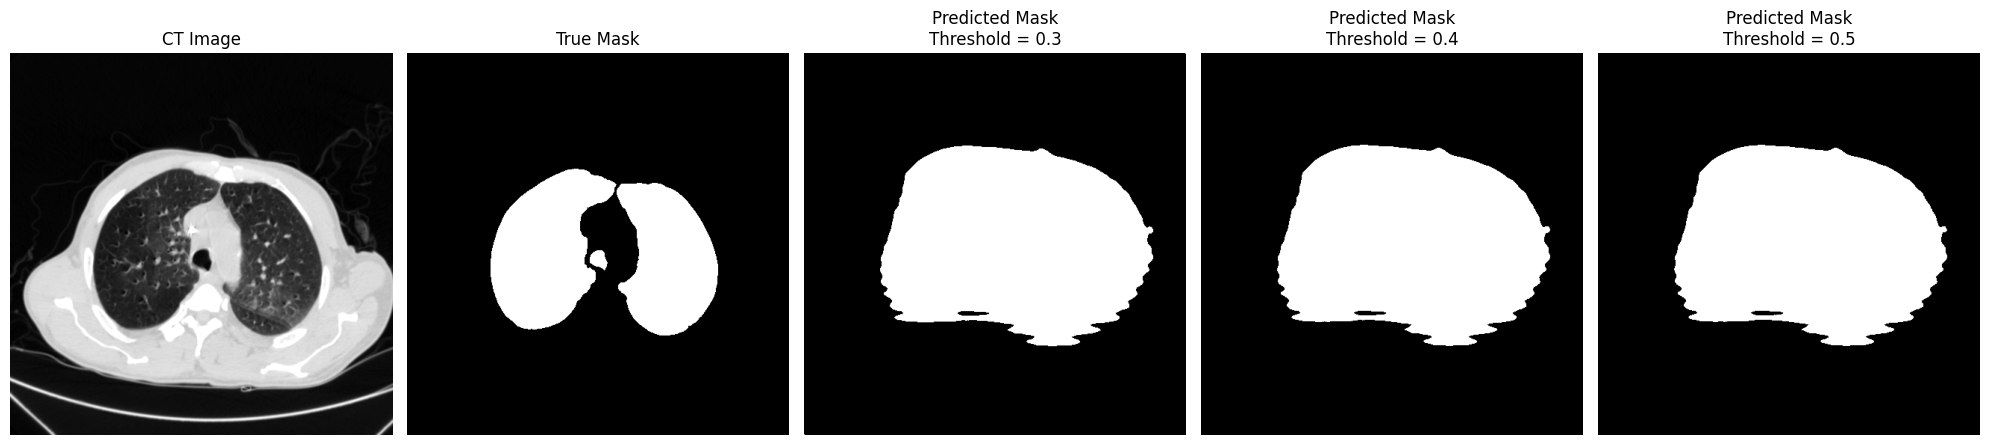

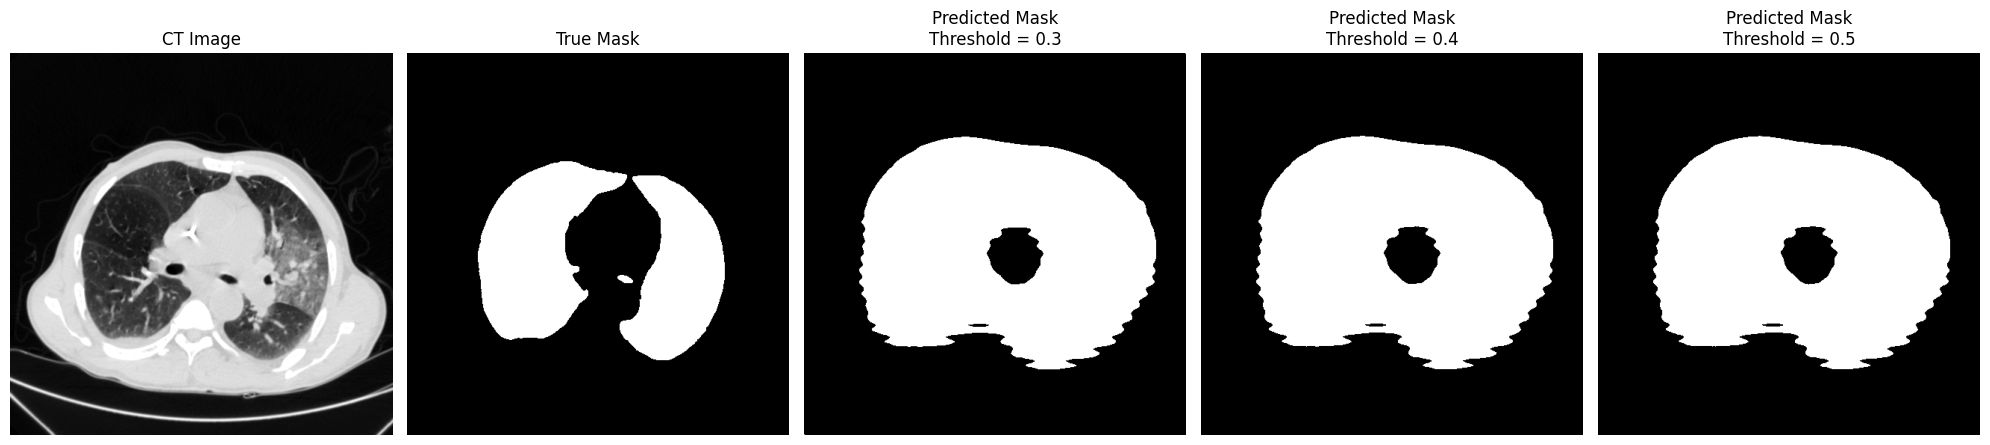

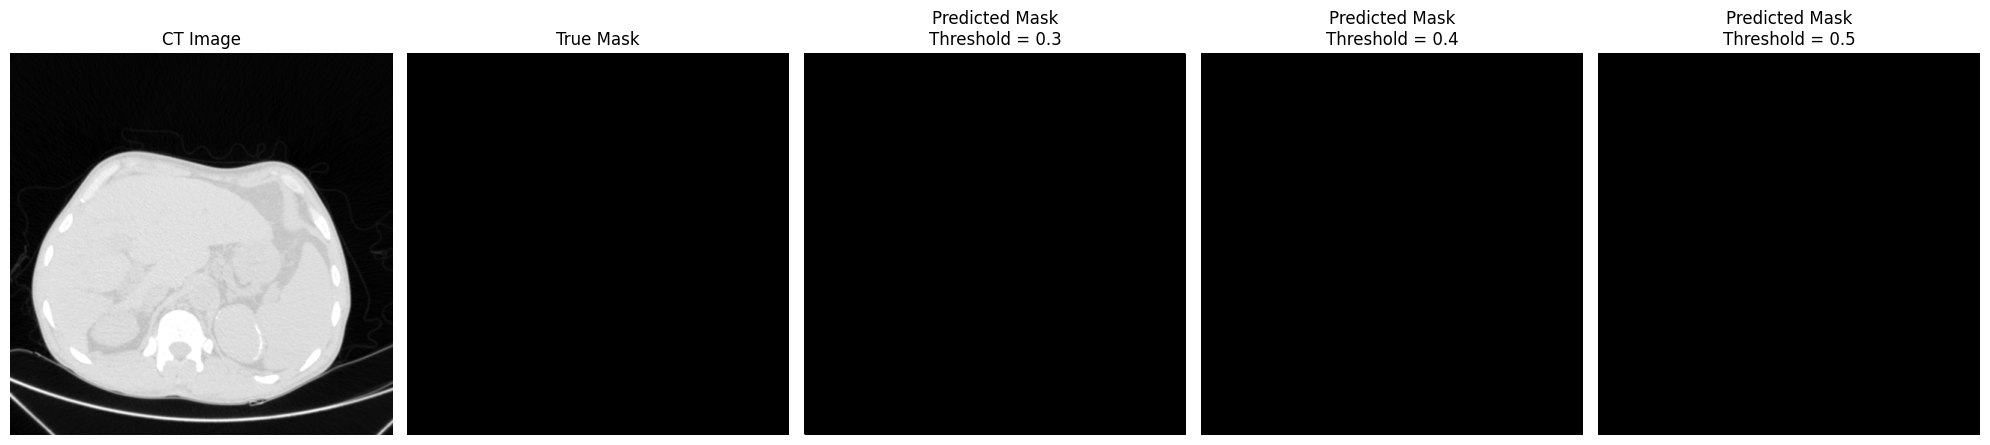

In [ ]:
# Plot the Input, True Mask, and Predicted Mask
visualize_with_multiple_thresholds(model, segment_val, num_samples=3)

**Note:** You can add more trials and explore different hyperparameters and design decisions as you want.

------------------------------

# Assignment 02
- Design your Deep Convolutional Neural Network using `Transfer Learning`
- You can select any pretrained model as a base and build on top.
- The task is to successfully classify images of cats and dogs using the dataset [here](https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip).
- There are no constraint; you have **full power**.

## `+` Downlaod, Load & Preprocess Cats & Dogs Data

### Download & Extract the Dataset

In [6]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  69.9M      0  0:00:11  0:00:11 --:--:-- 69.3M


In [14]:
!unzip -q kagglecatsanddogs_5340.zip
!ls -Rd PetImages/*

replace PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace PetImages/Cat/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace PetImages/Cat/10.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace PetImages/Cat/100.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace PetImages/Cat/1000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace PetImages/Cat/10000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A

PetImages/Cat  PetImages/Dog


In [15]:
# Delete Corrupted Images

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1590 images.


## `+` Set Global Parameters

In [17]:
SEED = 524
BATCH_SIZE = 8
EPOCHS = 20

### Load & Preprocess the Dataset

**Reminder:** You might need rescaling, data augmentation, and/or other preprocessing methods.

In [18]:
train_ds, val_ds = image_dataset_from_directory('PetImages',
                                                batch_size=BATCH_SIZE,
                                                seed=SEED,
                                                image_size=(180,180),
                                                validation_split=0.2,
                                                subset="both")

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


### Preview the Images

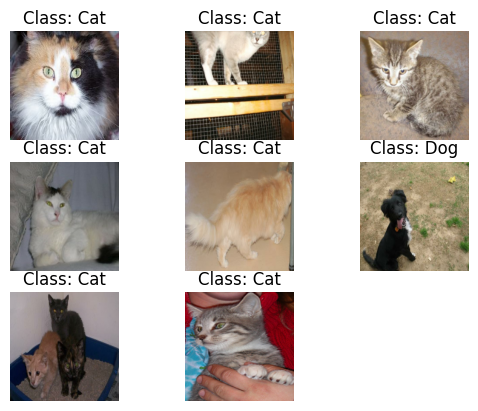

In [12]:
for images, labels in train_ds.take(1):
  for i in range(8):
    plt.subplot(3, 3, i+1)
    plt.imshow(np.array(images[i]).astype('uint8'))
    plt.title(f'Class: {["Cat", "Dog"][labels[i]]}')
    plt.axis('off')

In [34]:
for image, mask in train_ds.take(1):
    print("Image shape:", image.shape)
    print("Mask shape:", mask.shape)


Image shape: (8, 180, 180, 3)
Mask shape: (8,)


## `i` Model Design

In [13]:
inputs = Input((180, 180, 3))
x = Rescaling(1./255)(inputs)

x = Conv2D(32, (3,3), activation='relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D()(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

model_pet = Model(inputs, outputs)

model_pet.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 118336)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     7,573,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,593,025 (28.97 MB)

 Trainable params: 7,593,025 (28.97 MB)

 Non-trainable params: 0 (0.00 B)

## `ii` Model Compilation & Training

In [14]:
model_pet.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [15]:
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

In [16]:
history_pet = model_pet.fit(
    x =train_ds,
    validation_data=val_ds,
    epochs= EPOCHS,
    callbacks=[early_stop]
)

Epoch 1/20
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.6157 - loss: 0.7117 - val_accuracy: 0.7390 - val_loss: 0.5498
Epoch 2/20
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 30s 13ms/step - accuracy: 0.7641 - loss: 0.4908 - val_accuracy: 0.7411 - val_loss: 0.5242
Epoch 3/20
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 33s 14ms/step - accuracy: 0.8545 - loss: 0.3340 - val_accuracy: 0.7392 - val_loss: 0.6626
Epoch 4/20
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - accuracy: 0.9298 - loss: 0.1718 - val_accuracy: 0.7405 - val_loss: 1.1126
Epoch 5/20
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 38s 16ms/step - accuracy: 0.9685 - loss: 0.0865 - val_accuracy: 0.7232 - val_loss: 1.5446
Epoch 6/20
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 35s 13ms/step - accuracy: 0.9790 - loss: 0.0618 - val_accuracy: 0.7238 - val_loss: 1.3848
Epoch 7/20
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 46s 16ms/step - accuracy: 0.9846 - loss: 0.0473 - val_accuracy: 0.7196 - val_loss: 1.9290
Epoch 8/20
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.9872 -

## `iii` Model Evaluation

In [17]:
# Evaluate on training data
loss_train, accuracy_train = model_pet.evaluate(train_ds)
print(f"Accuracy (Train): {accuracy_train:.4%}")

# Evaluate on validation data
loss_val, accuracy_val = model_pet.evaluate(val_ds)
print(f"Accuracy (Validation): {accuracy_val:.4%}")


2341/2341 ━━━━━━━━━━━━━━━━━━━━ 35s 15ms/step - accuracy: 0.8276 - loss: 0.4028
Accuracy (Train): 83.9919%
586/586 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7364 - loss: 0.5253
Accuracy (Validation): 74.1136%


## `iv` Result Visualization

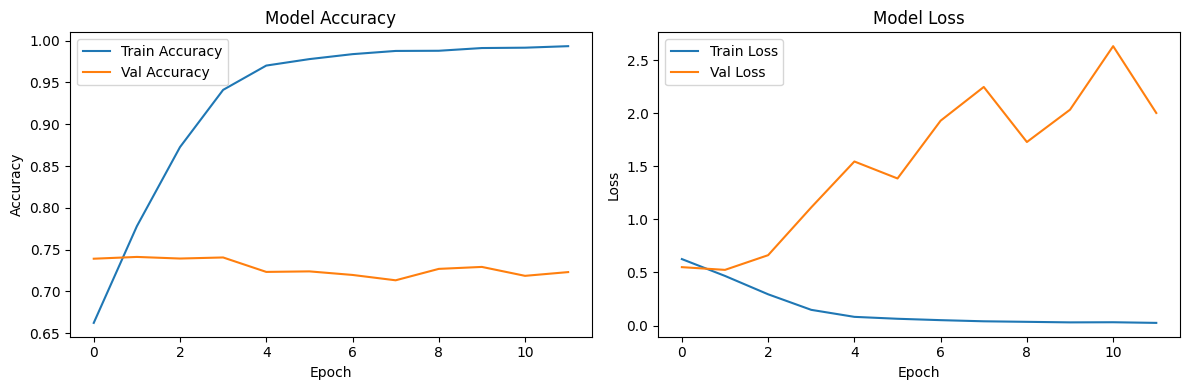

In [18]:
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_pet.history['accuracy'], label='Train Accuracy')
plt.plot(history_pet.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_pet.history['loss'], label='Train Loss')
plt.plot(history_pet.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


---
## `#` Transfer Model

## `i` Model Design

In [22]:
base_model = MobileNetV2(input_shape=(180, 180, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False  # Freeze base

model_pet_UNet = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')
])


<ipython-input-22-384a6c6a6f03>:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(180, 180, 3),


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## `ii` Model Compilation & Training

In [23]:
model_pet_UNet.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [24]:
history_pet_UNet = model_pet_UNet.fit(
     x= train_ds,
    validation_data=val_ds,
    epochs= EPOCHS
)

Epoch 1/20
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 61s 23ms/step - accuracy: 0.6854 - loss: 0.5943 - val_accuracy: 0.7399 - val_loss: 0.5288
Epoch 2/20
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 64s 17ms/step - accuracy: 0.7475 - loss: 0.5100 - val_accuracy: 0.7550 - val_loss: 0.5108
Epoch 3/20
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 45s 18ms/step - accuracy: 0.7590 - loss: 0.4893 - val_accuracy: 0.7463 - val_loss: 0.5196
Epoch 4/20
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 76s 16ms/step - accuracy: 0.7643 - loss: 0.4799 - val_accuracy: 0.7251 - val_loss: 0.5560
Epoch 5/20
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 40s 17ms/step - accuracy: 0.7692 - loss: 0.4744 - val_accuracy: 0.7443 - val_loss: 0.5277
Epoch 6/20
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 39s 17ms/step - accuracy: 0.7735 - loss: 0.4707 - val_accuracy: 0.7595 - val_loss: 0.5139
Epoch 7/20
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 44s 19ms/step - accuracy: 0.7751 - loss: 0.4664 - val_accuracy: 0.7616 - val_loss: 0.5016
Epoch 8/20
2341/2341 ━━━━━━━━━━━━━━━━━━━━ 39s 17ms/step - accuracy: 0.7775 -

## `iii` Model Evaluation

In [25]:
# Evaluate on training data
loss_train, accuracy_train = model_pet_UNet.evaluate(train_ds)
print(f"Accuracy (Train): {accuracy_train:.4%}")

# Evaluate on validation data
loss_val, accuracy_val = model_pet_UNet.evaluate(val_ds)
print(f"Accuracy (Validation): {accuracy_val:.4%}")


2341/2341 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - accuracy: 0.7955 - loss: 0.4356
Accuracy (Train): 79.5066%
586/586 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.7563 - loss: 0.5241
Accuracy (Validation): 75.8437%


## `iv` Result Visualization

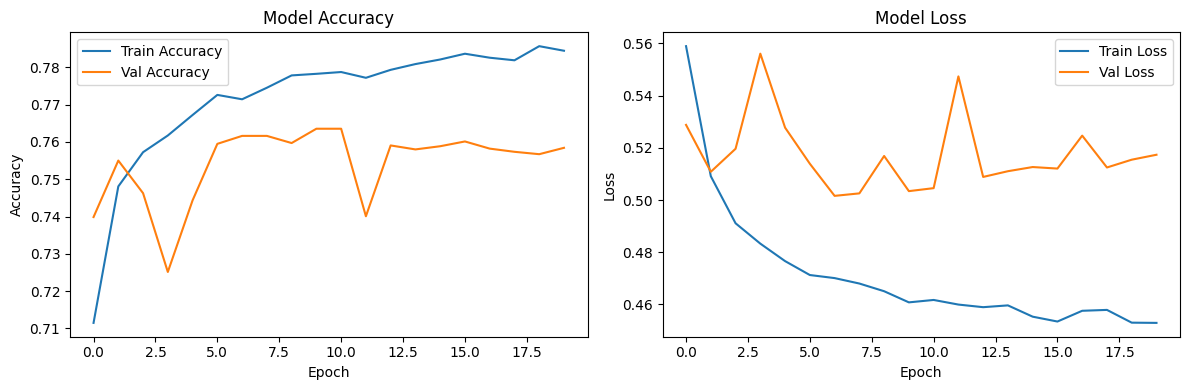

In [26]:
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_pet_UNet.history['accuracy'], label='Train Accuracy')
plt.plot(history_pet_UNet.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_pet_UNet.history['loss'], label='Train Loss')
plt.plot(history_pet_UNet.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## `v` Let's Test Our Model

Let's try to predict the class of some validation samples and plot the results.

Also, try to classify an image from the internet.

**Note:** remember to properly process the image (dimensions, rescaling, etc.)

In [33]:
for images, masks in val_ds.take(1):
  preds = model_pet.predict(images)

  print("Images shape:", images.shape)
  print("Masks shape:", masks.shape)
  print("Preds shape:", preds.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Images shape: (8, 180, 180, 3)
Masks shape: (8,)
Preds shape: (8, 1)


In [48]:
def visualize_classification_predictions(model, val_ds, num_samples=5, threshold=0.5):
    for images, labels in val_ds.take(1):
        preds = model.predict(images)
        preds = preds.squeeze()

        print("Images shape:", images.shape)
        print("Labels shape:", labels.shape)
        print("Predictions shape:", preds.shape)

        for i in range(min(num_samples, len(images))):
            img = images[i].numpy()

            if img.max() > 1.0:
                img = img / 255.0

            plt.figure(figsize=(4, 4))
            plt.imshow(img)
            plt.title(
                f"True: {int(labels[i].numpy())} | "
                f"Pred: {float(preds[i]):.2f} → Class {int(preds[i] > threshold)}"
            )
            plt.axis('off')
            plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Images shape: (8, 180, 180, 3)
Labels shape: (8,)
Predictions shape: (8,)


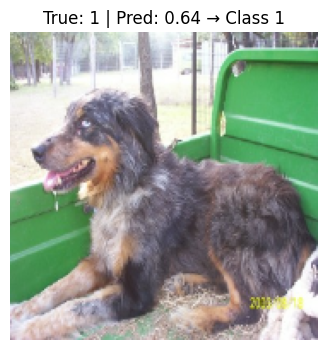

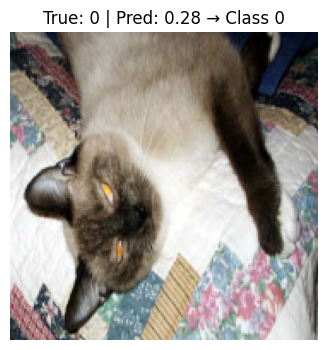

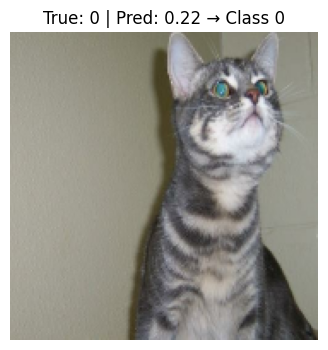

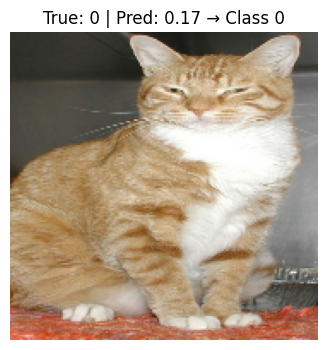

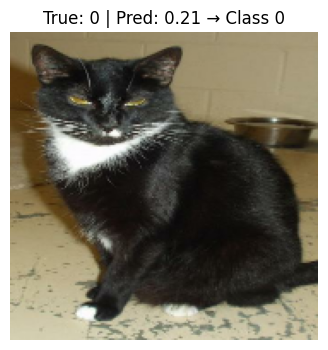

In [49]:
visualize_classification_predictions(model_pet_UNet, val_ds, num_samples=5)

## `#` Classify an image from the internet.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


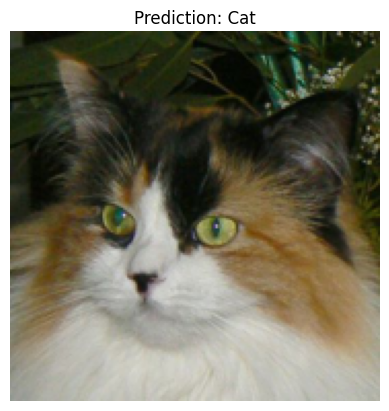

In [39]:
# Download an image from the internet
url = 'https://www.naturemobile.org/media/species/images_360/1300036.jpg'
response = requests.get(url)
img = Image.open(BytesIO(response.content))

# Preprocess the image
img = img.resize((180, 180))
img_array = tf.convert_to_tensor(np.array(img))
img_array = tf.image.convert_image_dtype(img_array, dtype=tf.float32)
img_array = tf.expand_dims(img_array, axis=0)

# Predict with the model
prediction = model_pet_UNet.predict(img_array)

#  Visualize the result
plt.imshow(img)
plt.title(f"Prediction: {'Cat' if prediction[0] < 0.5 else 'Dog'}")
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


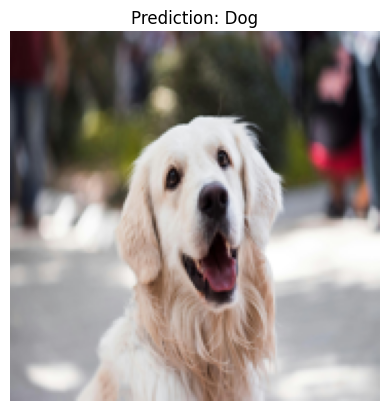

In [40]:
# Download an image from the internet
url = 'https://images.pexels.com/photos/1490908/pexels-photo-1490908.jpeg?cs=srgb&dl=pexels-svetozar-milashevich-99573-1490908.jpg&fm=jpg'
response = requests.get(url)
img = Image.open(BytesIO(response.content))

# Preprocess the image
img = img.resize((180, 180))
img_array = tf.convert_to_tensor(np.array(img))
img_array = tf.image.convert_image_dtype(img_array, dtype=tf.float32)
img_array = tf.expand_dims(img_array, axis=0)

# Predict with the model
prediction = model_pet_UNet.predict(img_array)

#  Visualize the result
plt.imshow(img)
plt.title(f"Prediction: {'Cat' if prediction[0] < 0.5 else 'Dog'}")
plt.axis('off')
plt.show()


----------------------------------------------

$$ Wish \space you \space all \space the \space best \space ♡ $$
